In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
#pip install xgboost


In [3]:
df = pd.read_csv('incoming_daily_till2023may_interpolated.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    881 non-null    object 
 1   volume  881 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.9+ KB


In [5]:
# Assuming 'timestamp' is the column containing the irregular timestamps and 'value' is the column containing the volume data
df['date'] = pd.to_datetime(df['date'],format="%Y/%m/%d")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    881 non-null    datetime64[ns]
 1   volume  881 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.9 KB


In [7]:
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 881 entries, 2021-01-01 to 2023-05-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   volume  881 non-null    float64
dtypes: float64(1)
memory usage: 13.8 KB


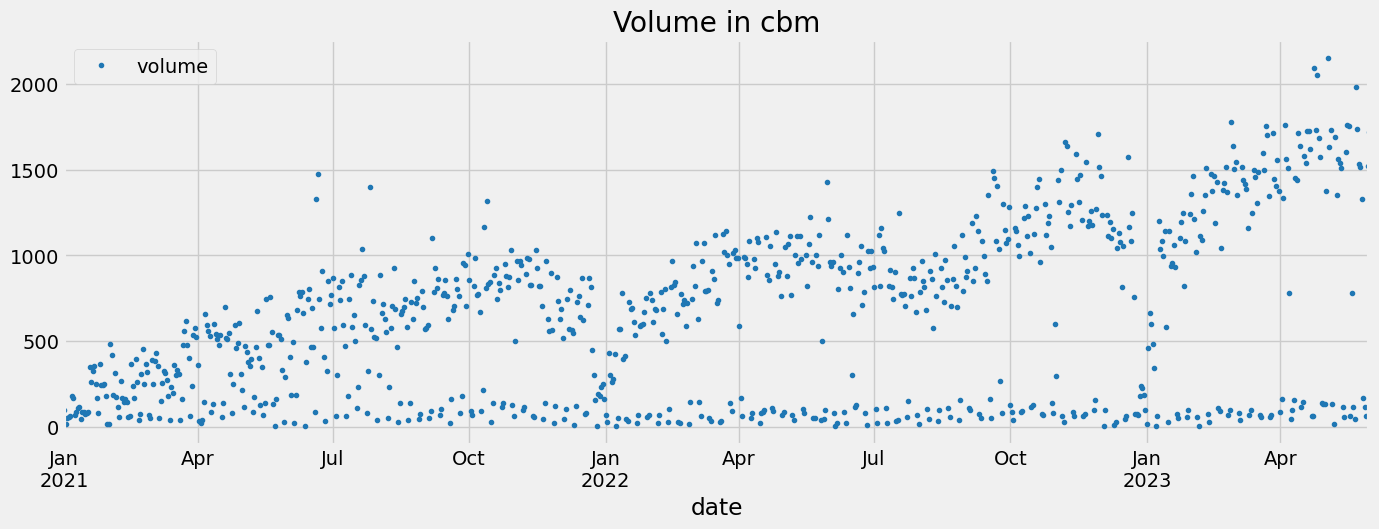

In [9]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Volume in cbm')
plt.show()

<AxesSubplot:xlabel='date'>

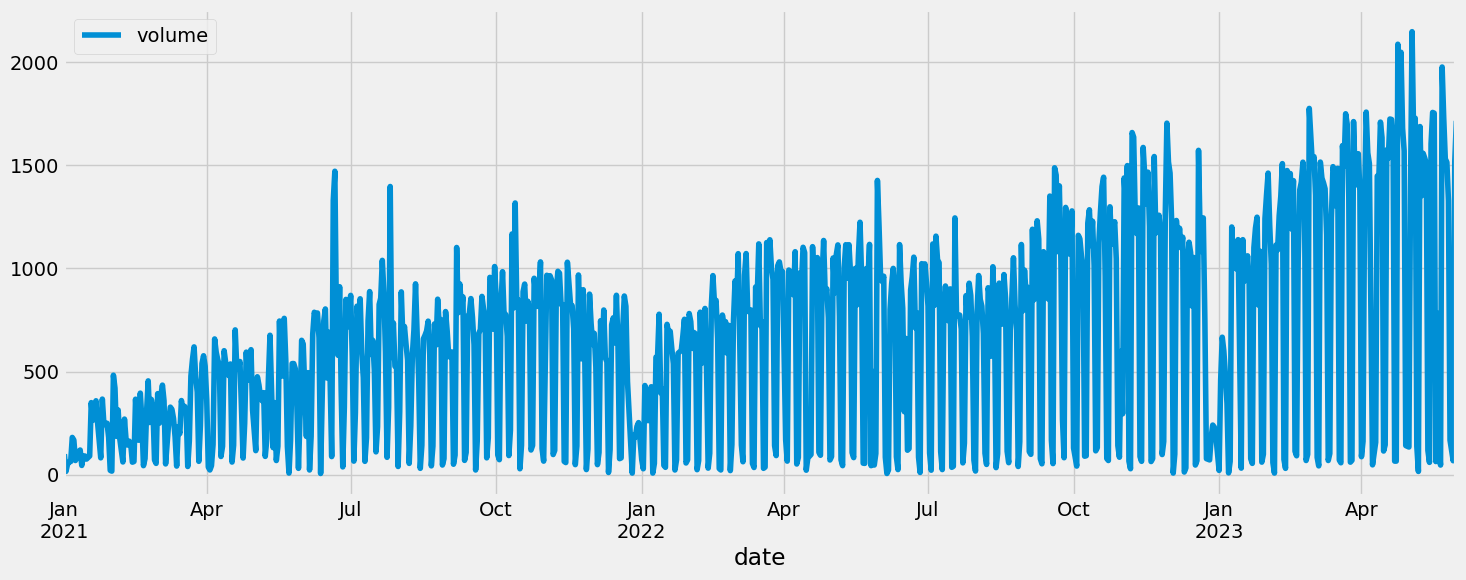

In [10]:
#plt.subplot(111)   #no of rows on y-axis,, 
df['volume'].plot(figsize=(16, 6), legend=True)

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=7, shuffle=False)
train.columns = df.columns
test.columns = df.columns
print(f"{train.shape[0]} train and {test.shape[0]} test instances")

704 train and 177 test instances


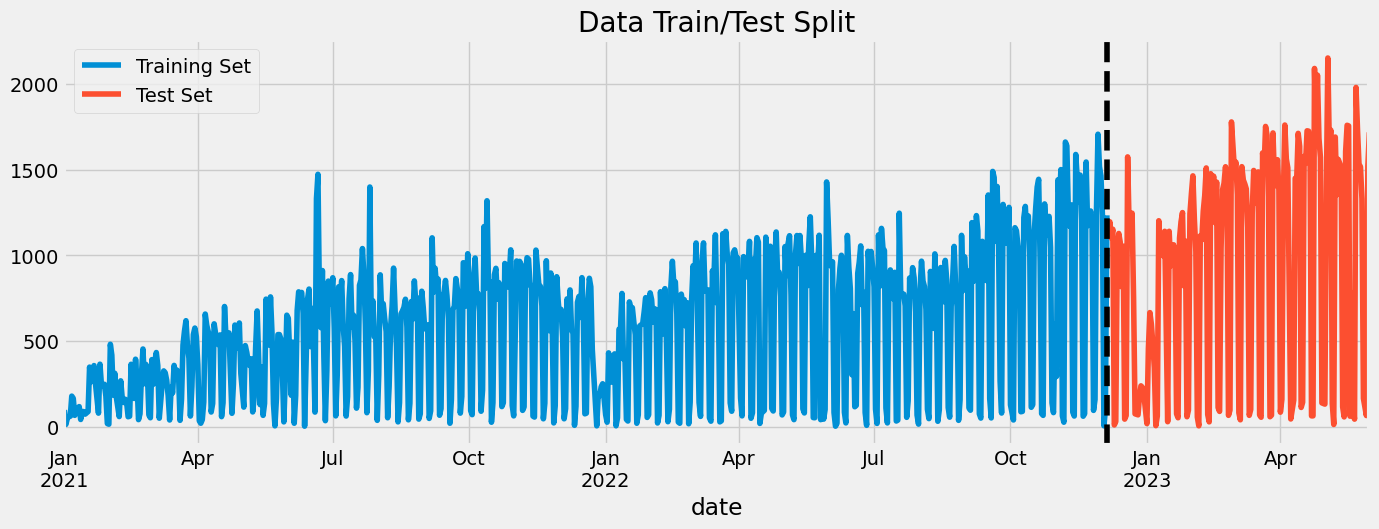

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('12-05-2022', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

#5th dec 2022


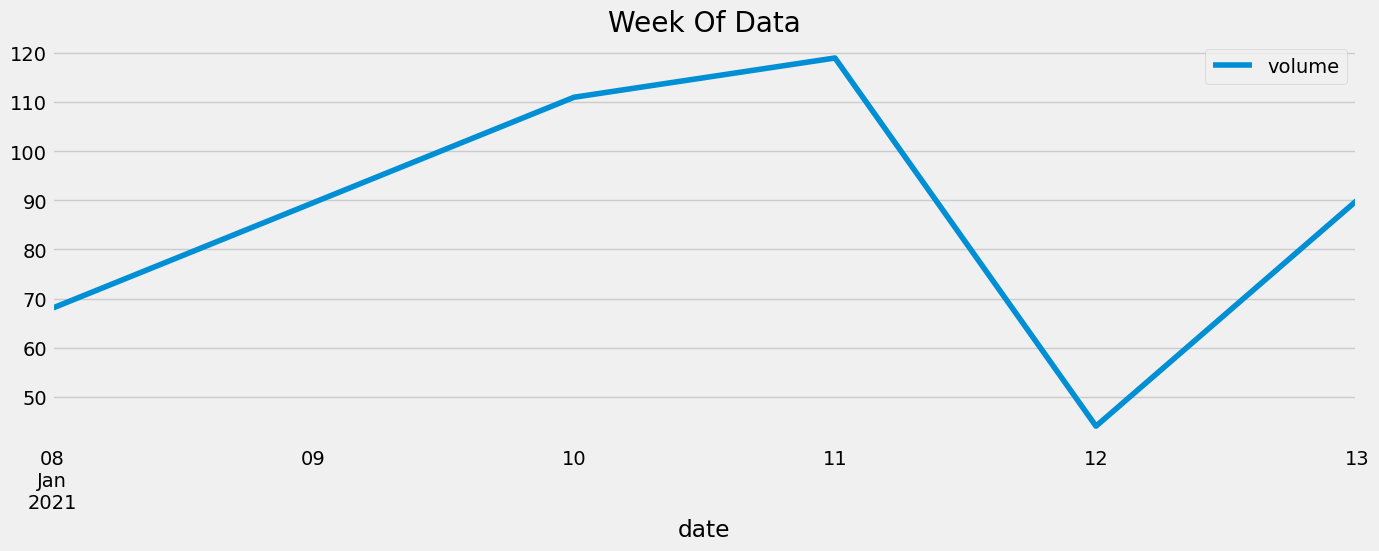

In [13]:
df.loc[(df.index > '01-07-2021') & (df.index < '01-14-2021')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [14]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

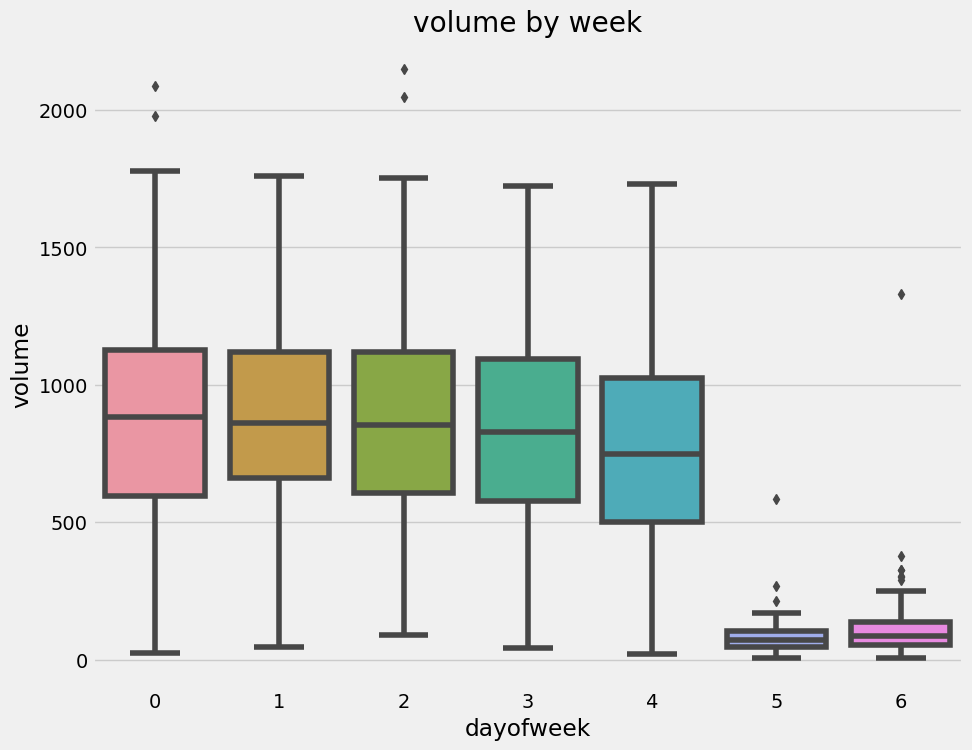

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='volume')
ax.set_title('volume by week')
plt.show()   #monday 0--sunday 6

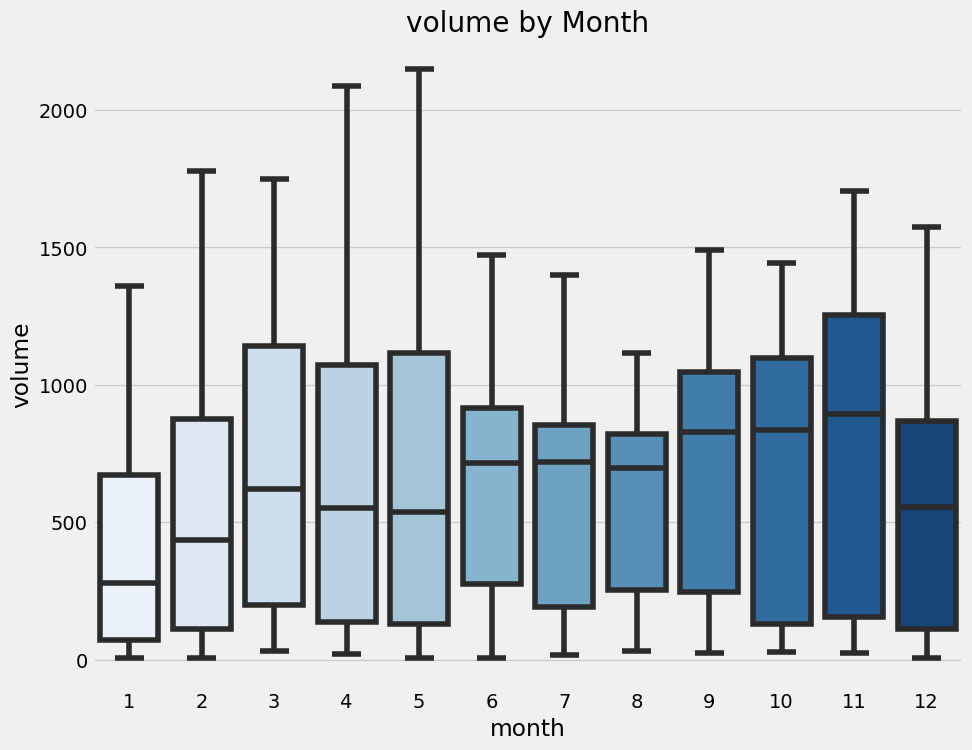

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='volume', palette='Blues')
ax.set_title('volume by Month')
plt.show()

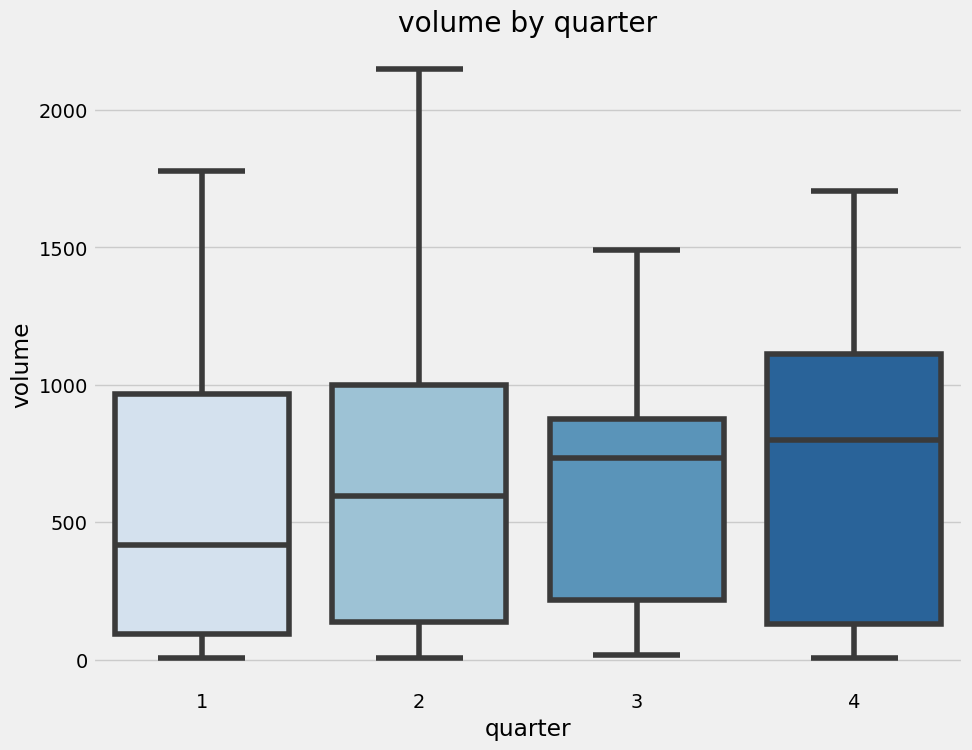

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='quarter', y='volume', palette='Blues')
ax.set_title('volume by quarter')
plt.show()

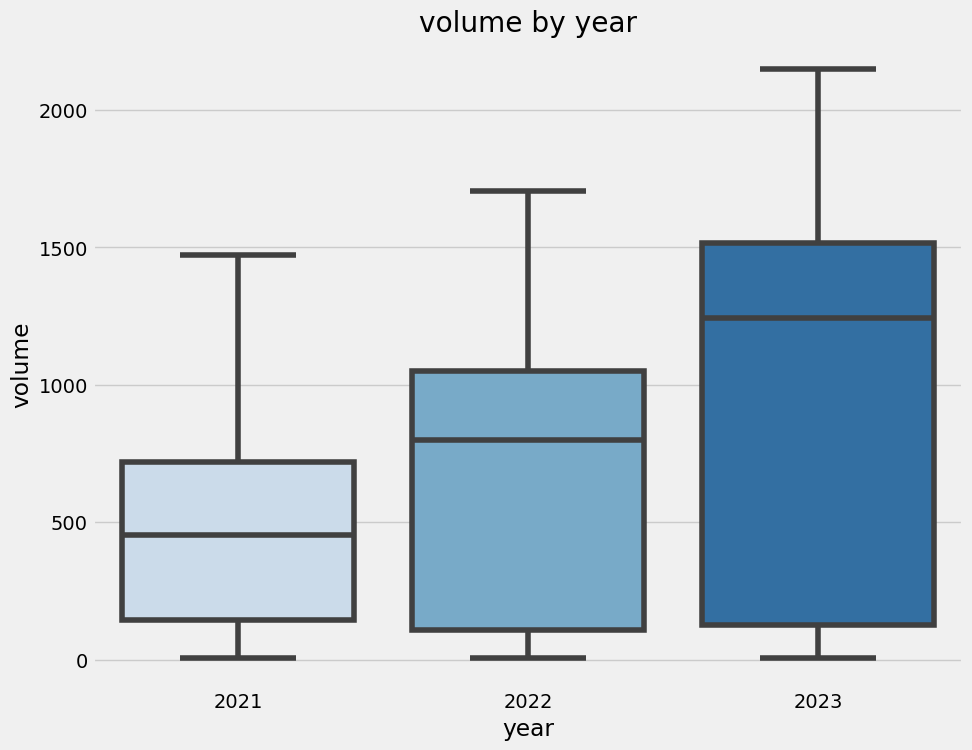

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='year', y='volume', palette='Blues')
ax.set_title('volume by year')
plt.show()

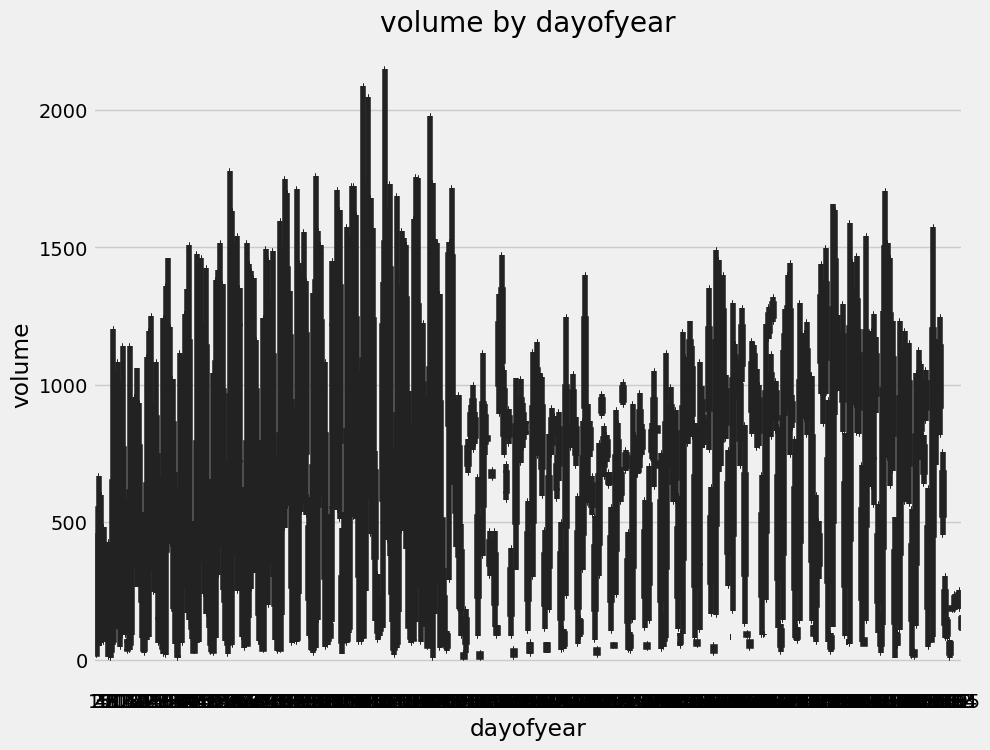

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofyear', y='volume', palette='Blues')
ax.set_title('volume by dayofyear')
plt.show()

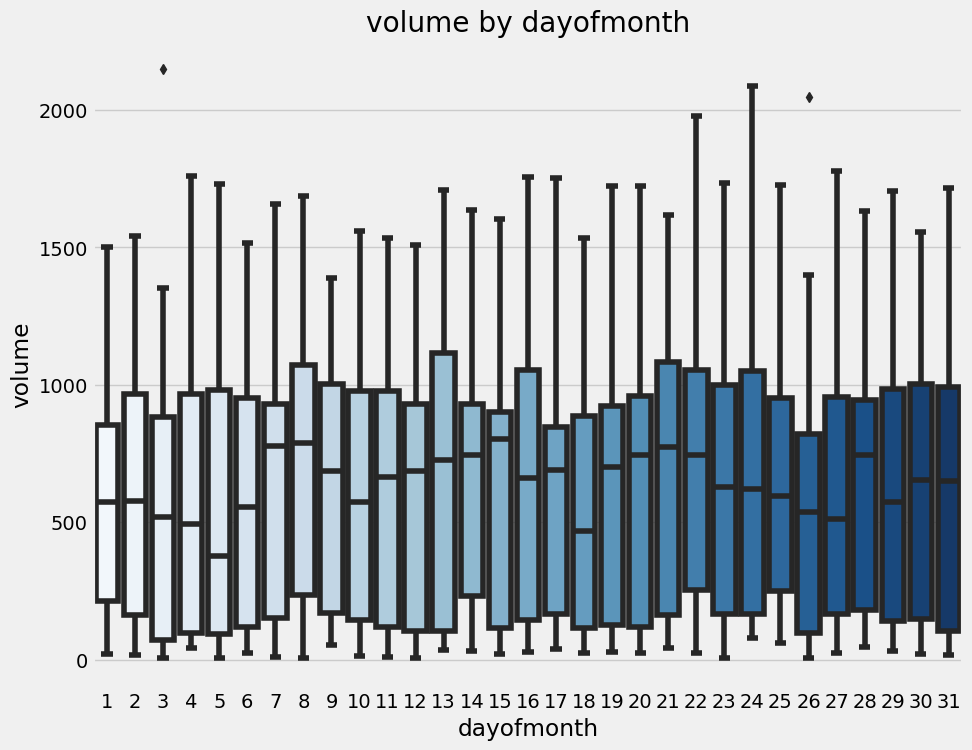

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofmonth', y='volume', palette='Blues')
ax.set_title('volume by dayofmonth')
plt.show()

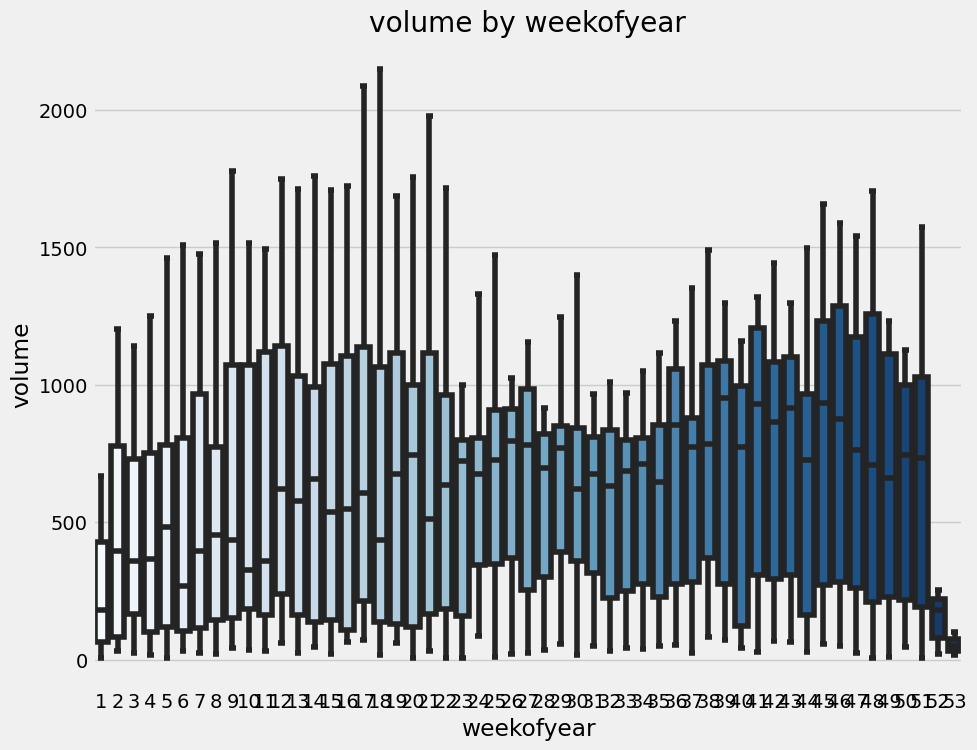

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='weekofyear', y='volume', palette='Blues')
ax.set_title('volume by weekofyear')
plt.show()

In [22]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofweek', 'quarter', 'month', 'year']
TARGET = 'volume'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [23]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,   #stop the model training early if the test set is not improving after 50 trees
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01) #so that it doesn't overfit the model
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100) #give output of trees based on interval of 100

[19:47:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:691.15661	validation_1-rmse:1131.91681
[100]	validation_0-rmse:310.61149	validation_1-rmse:724.34211
[200]	validation_0-rmse:201.33577	validation_1-rmse:602.41793
[300]	validation_0-rmse:176.49152	validation_1-rmse:563.15682
[400]	validation_0-rmse:169.01401	validation_1-rmse:551.09679
[476]	validation_0-rmse:166.86231	validation_1-rmse:549.43882


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [24]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,   #stop the model training early if the test set is not improving after 50 trees
                       objective='reg:linear',
                       max_depth=3,
                    ) #so that it doesn't overfit the model
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        ) #give output of trees based on interval of 100

[19:47:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:509.12614	validation_1-rmse:936.37448
[1]	validation_0-rmse:382.54938	validation_1-rmse:798.59192
[2]	validation_0-rmse:301.15252	validation_1-rmse:706.60242
[3]	validation_0-rmse:248.77446	validation_1-rmse:663.92202
[4]	validation_0-rmse:214.19022	validation_1-rmse:622.99898
[5]	validation_0-rmse:195.32951	validation_1-rmse:592.07890
[6]	validation_0-rmse:184.35411	validation_1-rmse:579.83566
[7]	validation_0-rmse:177.28112	validation_1-rmse:569.51314
[8]	validation_0-rmse:173.25797	validation_1-rmse:562.40585
[9]	validation_0-rmse:170.88286	validation_1-rmse:554.46267
[10]	validation_0-rmse:169.19899	validation_1-rmse:554.18990
[11]	validation_0-rmse:168.10538	validation_1-rmse:549.05743
[12]	validation_0-rmse:167.12316	validation_1-r

[131]	validation_0-rmse:155.32546	validation_1-rmse:542.07531
[132]	validation_0-rmse:155.31452	validation_1-rmse:541.85800
[133]	validation_0-rmse:155.29288	validation_1-rmse:541.86720
[134]	validation_0-rmse:155.28025	validation_1-rmse:542.24461
[135]	validation_0-rmse:155.25347	validation_1-rmse:542.24998
[136]	validation_0-rmse:155.23581	validation_1-rmse:542.34136
[137]	validation_0-rmse:155.22088	validation_1-rmse:542.42472
[138]	validation_0-rmse:155.20890	validation_1-rmse:542.51679
[139]	validation_0-rmse:155.19940	validation_1-rmse:542.11645
[140]	validation_0-rmse:155.19356	validation_1-rmse:542.28811
[141]	validation_0-rmse:155.17262	validation_1-rmse:541.76833
[142]	validation_0-rmse:155.15082	validation_1-rmse:541.87707
[143]	validation_0-rmse:155.12925	validation_1-rmse:541.63683
[144]	validation_0-rmse:155.11389	validation_1-rmse:541.88918
[145]	validation_0-rmse:155.10738	validation_1-rmse:541.59212
[146]	validation_0-rmse:155.08878	validation_1-rmse:541.40233
[147]	va

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

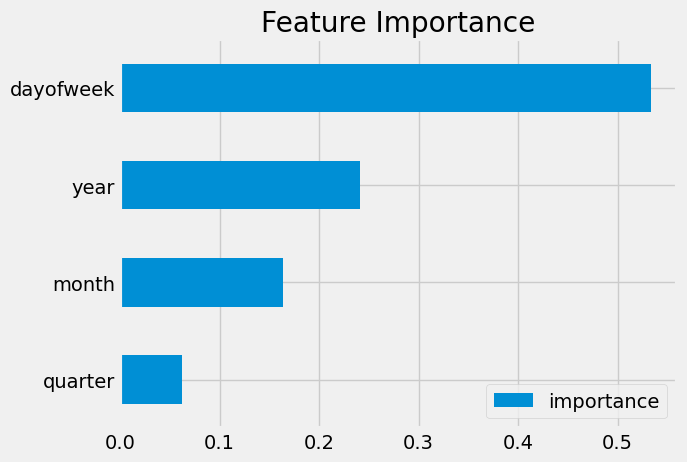

In [25]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

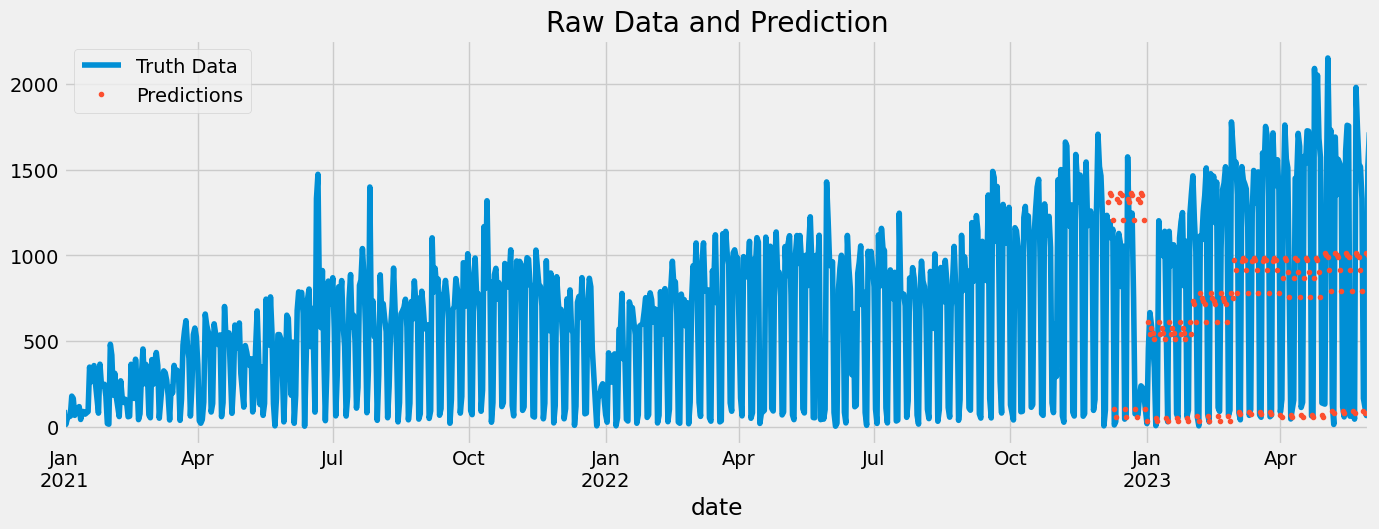

In [26]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['volume']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

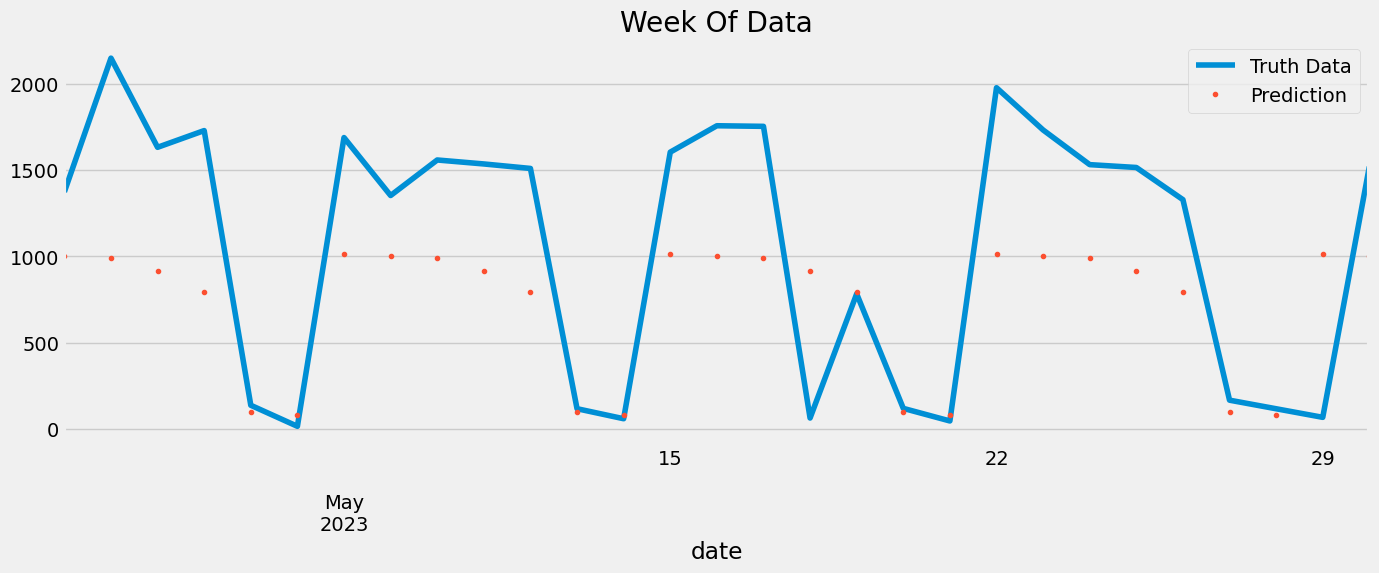

In [27]:
ax = df.loc[(df.index > '05-01-2023') & (df.index < '05-31-2023')]['volume'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '05-01-2023') & (df.index < '05-31-2023')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [28]:
score = np.sqrt(mean_squared_error(test['volume'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 541.32


In [33]:
# 4. Evaluate the Model
predicted = test['prediction']
actual = test['volume']

# Calculate RMSE
rmse = np.sqrt(((predicted - actual) ** 2).mean())
# Calculate MAE
mae = np.abs(predicted - actual).mean()
# Calculate MAPE
mape = (np.abs((actual - predicted) / actual)).mean() * 100
# Calculate Theil's U2
numerator = np.sqrt(np.sum((predicted - actual)**2) / len(actual))
denominator = np.sqrt((np.sum(actual**2) + np.sum(predicted**2)) / (2 * len(actual)))
theils_u2 = numerator / denominator

print(f"RMSE: {rmse}, MAE: {mae}, MAPE: {mape}%, Theil's U2: {theils_u2}")

RMSE: 541.3171132239074, MAE: 426.7139972320384, MAPE: 92.39320910646904%, Theil's U2: 0.5549812685508186


In [29]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date_test'] = test.index.date
test.groupby(['date_test'])['error'].mean().sort_values(ascending=False).head(10)   #worst predicted days

date_test
2022-12-26    1259.817139
2023-04-24    1221.155090
2023-05-03    1156.719177
2022-12-27    1126.068481
2022-12-29    1123.657349
2022-12-28    1122.789185
2023-04-26    1075.998230
2022-12-30    1020.333008
2023-02-27     994.373962
2023-05-22     963.797302
Name: error, dtype: float64

In [30]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date_test'] = test.index.date
test.groupby(['date_test'])['error'].mean().sort_values(ascending=True).head(10)   #best predicted days

date_test
2022-12-31    0.170250
2023-04-22    3.206108
2023-02-04    3.420429
2023-03-04    5.688423
2023-01-15    5.892139
2022-12-18    6.100655
2023-02-25    6.579571
2023-04-23    7.403019
2023-02-12    7.526253
2023-03-26    7.886559
Name: error, dtype: float64